#  What Drives Error? Clustering with Zillow

Presented by:  Sarah Lawson Woods 28 September 2021

## Executive Summary

Goals: The purpose of this project is create a regression model with using Kmeans clusters (if proven valuable) to predicts the drivers of logerror on Zillow homes in  the three counties of California (Los Angeles County, Orange County, and Ventura County).

Target: logerror which is the difference in the predicted zestimate and the actual home sale price.
Results: Best predictors discovered were number of bedrooms, number of bathrooms, and square footage this was confirmed by my visualizations and a pearson r test on these variables.

Findings: I created clusters with a focus on lot_size and area after exploring features further I realized bedrooms and bathrooms were more correlated features so I included them in my next cluster.  For my first cluster I ran a t-test comparing the mean of the 3 seperate clusters to look for a difference. I accepted that there is not significant difference between the clusters and the overall data. My other two clusters had similar results in that none of the clusters were proven statistically to be different than the others, so I was not able to incorporate them into my models as features.

Conclusion:
I did not find drivers of logerrror
My best model 3rd degree polynomial  did not beat my baseline model
With more time I would cluster on additional features to find something significant to use in my models.

Recommendations: Run additional clusters and models to get better results.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Exploring
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Modeling
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor


# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import math 
import wrangle_functions
import env
import acquire
import prepare

## Acquire

In [2]:
# using a SQL query I pull in the zillow data set for 2017 properties and predictions data for single 
# unit / single family homes from the Codeup database.
df = acquire.new_zillow_data()

In [3]:
# taking a look at the dataset
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,parcelid,basementsqft,...,id,parcelid,logerror,transactiondate,id,last_trans_date,propertylandusedesc,storydesc,typeconstructiondesc,parcelid
0,NaN,NaN,269.00,NaN,NaN,NaN,NaN,0,10754147,NaN,...,0,14297519,0.03,2017-01-01,0,2017-01-01,Planned Unit Development,None,None,10754147
1,NaN,NaN,261.00,NaN,NaN,NaN,NaN,1,10759547,NaN,...,1,17052889,0.06,2017-01-01,1,2017-01-01,Single Family Residential,None,None,10759547
2,NaN,NaN,47.00,NaN,5.00,NaN,NaN,2,10843547,NaN,...,2,14186244,0.01,2017-01-01,2,2017-01-01,Store/Office (Mixed Use),None,None,10843547
3,NaN,NaN,47.00,NaN,3.00,NaN,NaN,3,10859147,NaN,...,3,12177905,-0.10,2017-01-01,3,2017-01-01,Store/Office (Mixed Use),None,None,10859147
4,NaN,NaN,31.00,NaN,4.00,NaN,NaN,4,10879947,NaN,...,4,10887214,0.01,2017-01-01,4,2017-01-01,Commercial/Office/Residential Mixed Used,None,None,10879947


In [4]:
# Intially I will pull in 77,614 rows and 73 columns
df.shape

(77614, 73)

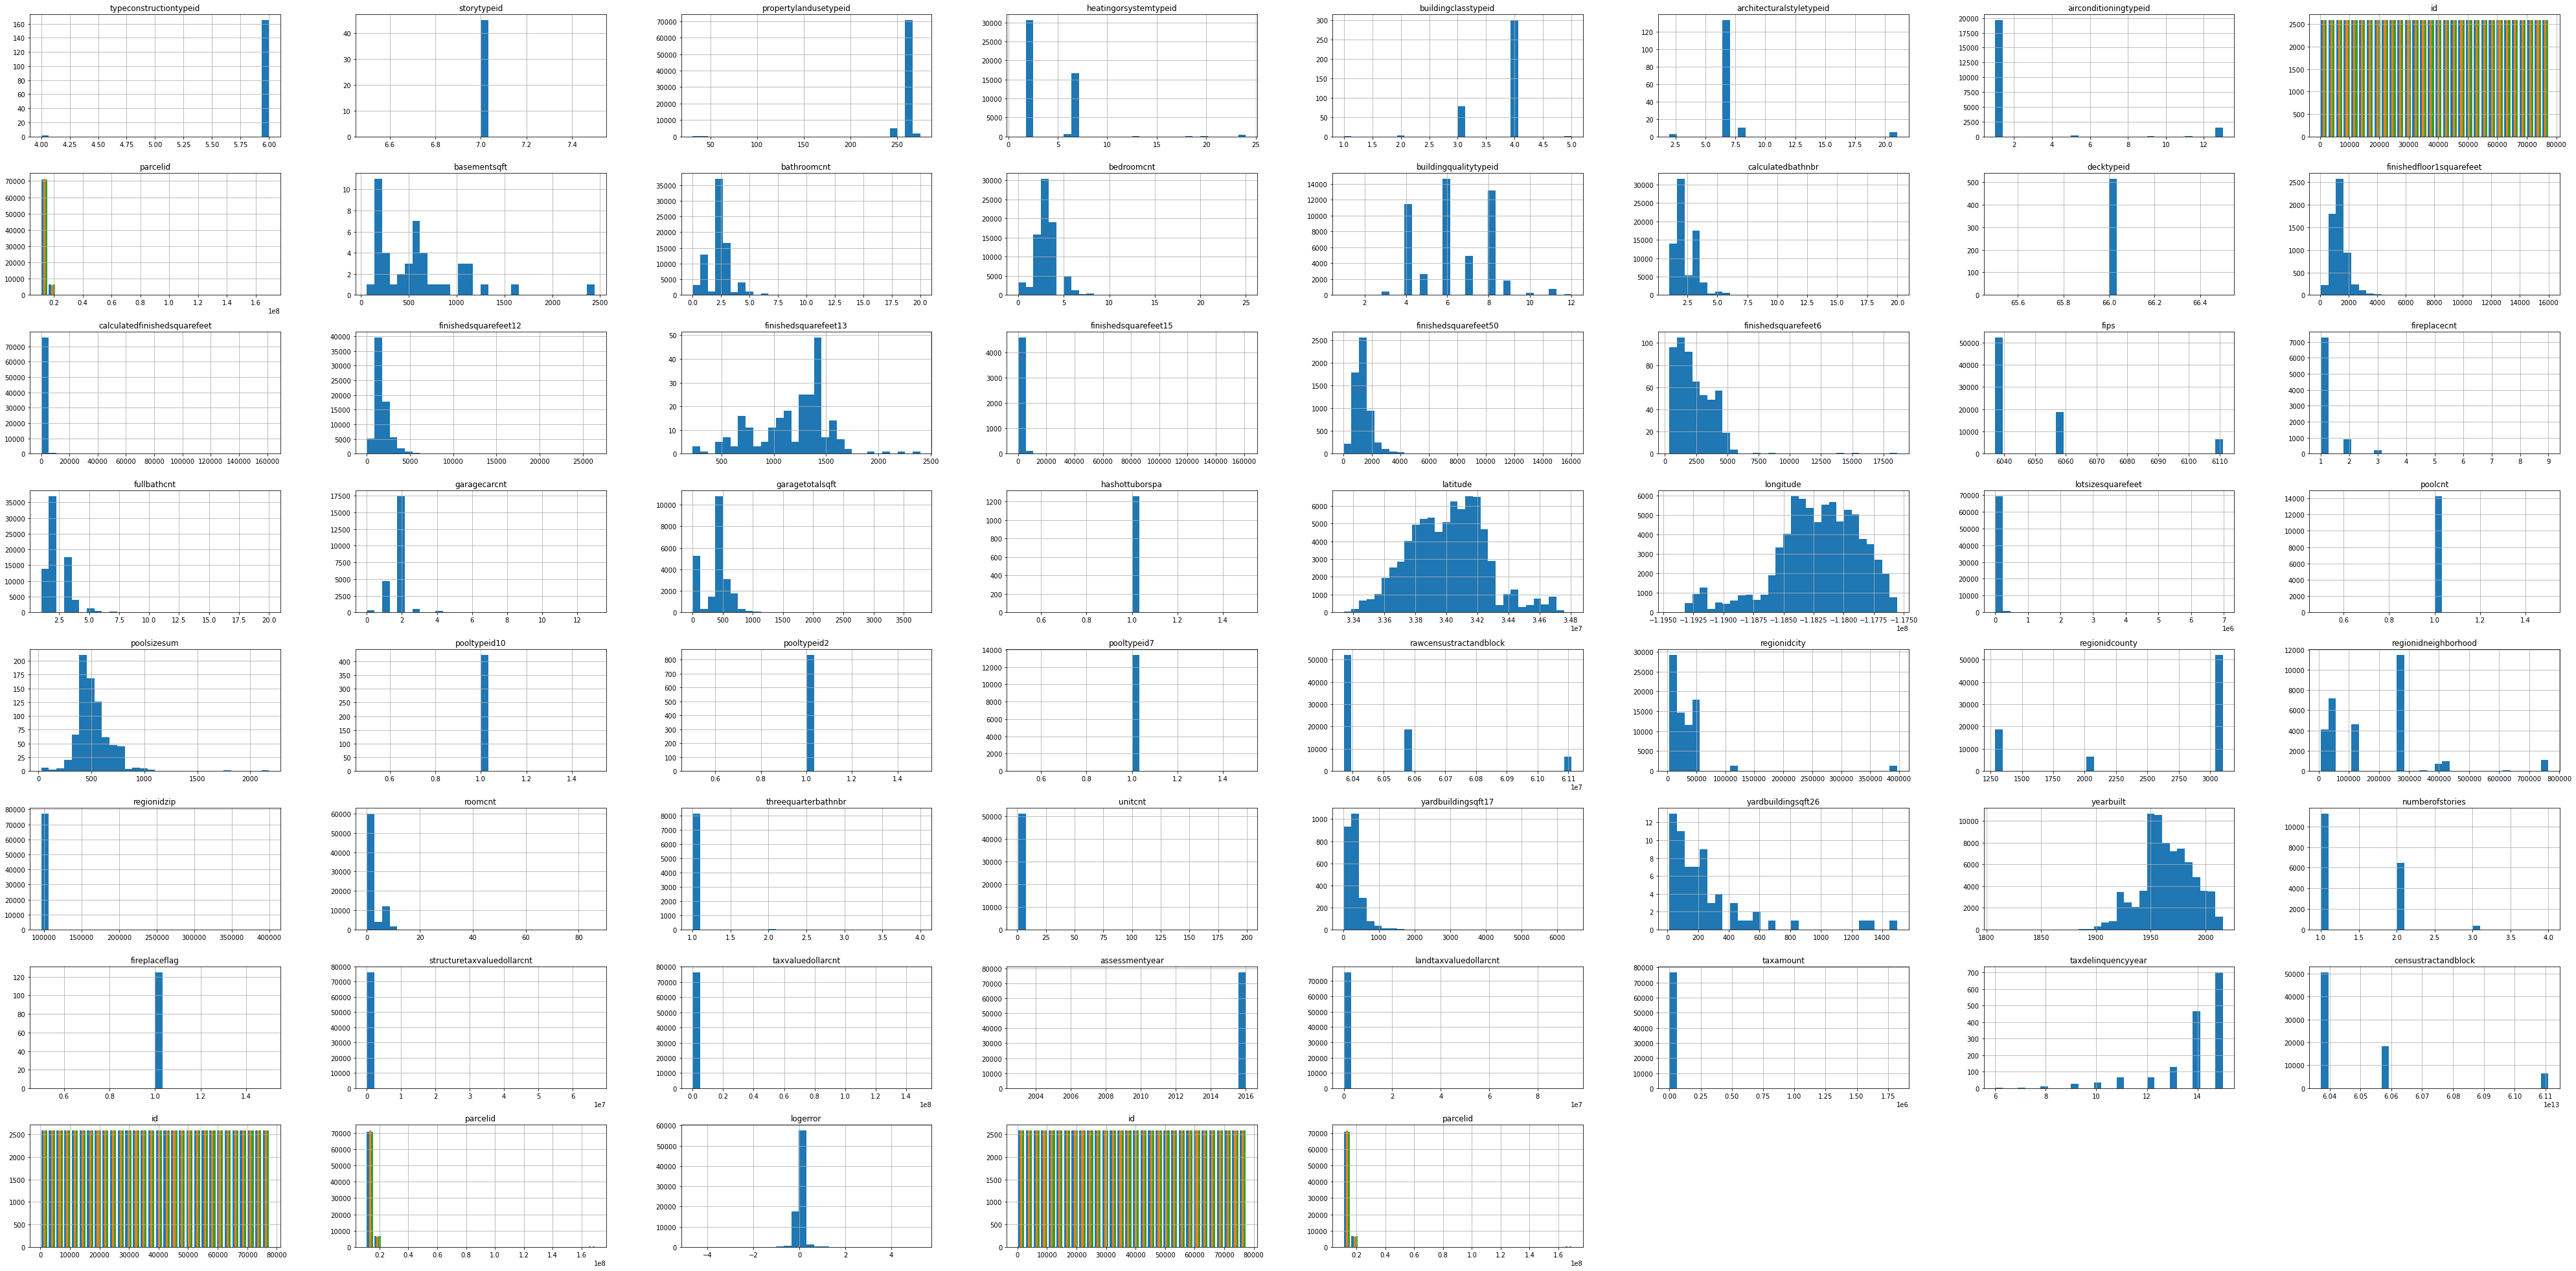

In [5]:
# plot histograms for all variables
df.hist(figsize=(70, 35), bins=30)
plt.show()

### Acquire Takeaways
- tax_value, landtaxvaluedollarcnt, bathrooms, bedrooms, area and logerror are normally distributed
- taxamount, structuretaxvaluedollarcnt is right skewed
- initially pulled in 77614 rows and  73 columns

## Prepare

In [6]:
# here I have applied all of my preparation techniques from the prepare.py file using the prep_all_function
df, df_outs = prepare.prep_all_function(df)

After I ran my prep_all_function I started by summarizing the dataset, next I chose the necessary columns from the original 73 that best represented the information I thought might be useful to explore, cluster with and model on.  I imputed columns as I saw fit and dropped columns with more than 25% of missing values.  I removed outliers using a function that took the most extreme outliers from the main dataframe, but kept most other outliers and saved this df to use in modeling.  Also created a separate df that is scaled to use in modeling.

In [7]:
# after prepartion is performed my dataset now consists of 57,795 rows and 14 columns
df.shape

(57795, 14)

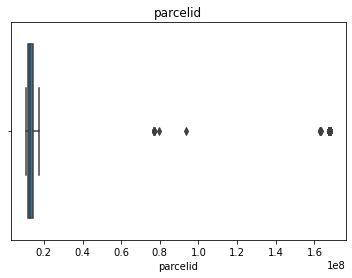

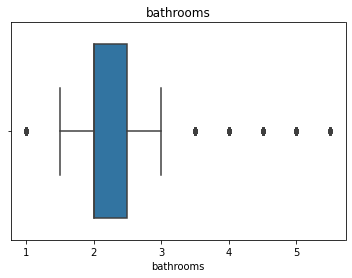

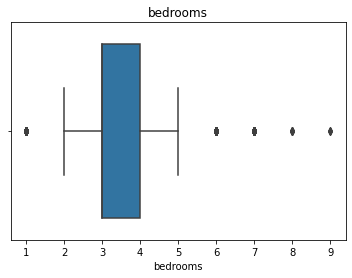

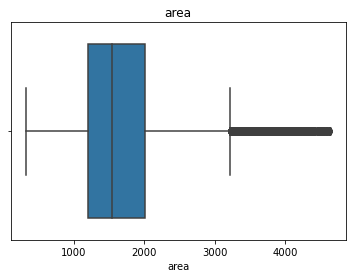

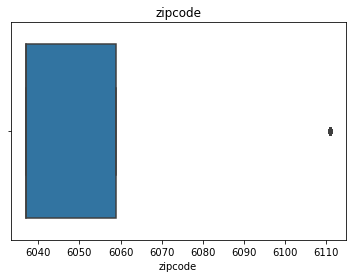

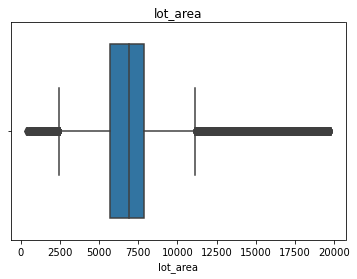

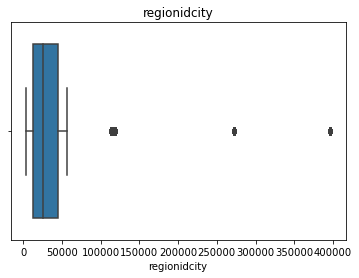

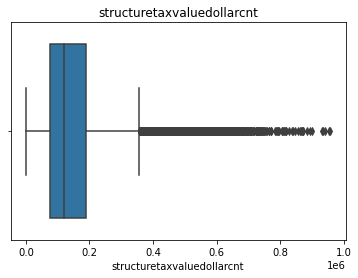

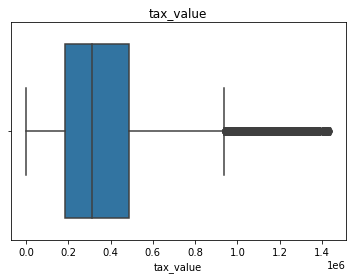

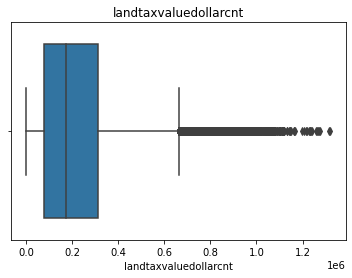

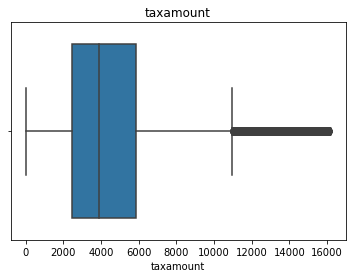

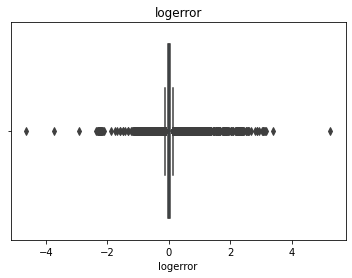

TypeError: Horizontal orientation requires numeric `x` variable.

In [8]:
# here are boxplots for all columns with some outliers removed
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

In [ ]:
df = df.drop(columns ="propertylandusedesc")

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

In [ ]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.train_validate_test(df, "logerror")

In [ ]:
# now I will create a df that is scaled
_, train_scaled, validate_scaled, test_scaled = wrangle_functions.min_max_scaler(train, validate, test)

### Prepare Takeaways 
- I ended up after all prepartion was acccomplished with 57795 rows and 14 columns before I split the dataframe into train, test, split.
- I also created a scaled dataframe with the min/max scaler to use for modeling
- I created a feature called large_home that classified a home with area over 2,300 to be in this category

## Explore

During this stage of the pipeline I explored the interaction between independent variables and with independenct variables and the target. My focus was on lot_area, and area I also tested by hypothesis through visualizations and statistical testing. Next I created clusters with these same variables since my visualizations indicated they had some correlation.

The topics of interest I would like to explore are:

    1. Is there a relationship between home lot_area and logerror?
    2. Is there a difference in logerror between small and large houses?(Viz size against logerror -Stats test      to confirm)
    
   

In [ ]:
#see what correlates most with logerror with heatmap
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16)

In [ ]:
# choosing my features for clustering based on the visual above I will explore bedrooms, bathrooms and the
# features listed in X_scaled
X_scaled = train_scaled[['area', 'lot_area']]

In [ ]:
# also want to explore bedrooms and bathrooms since they have a stronger correlation than my initial features

### Start Clustering

### Cluster 1

In [ ]:
# sklearn implementation of KMeans

#define it
kmeans_scaled = KMeans(n_clusters=3, random_state=777)

# fit it
kmeans_scaled.fit(X_scaled)

# Use/predict it
kmeans_scaled.predict(X_scaled)

In [ ]:
# make a new column names cluster in df and X_scaled dataframe and X dataframe
cluster_features = ['area', 'lot_area']

X_scaled['cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

X_scaled['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

In [ ]:
X_scaled.head()

In [ ]:
# here I am creating the centroids for the clusters on scaled data
centroids = X_scaled.groupby('scaled_cluster')['area', 'lot_area'].mean()

In [ ]:
# now I am going to plot the unscaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('scaled_cluster'):
    plt.scatter(subset.area, subset.lot_area, label='scaled cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='lot_area', x='area', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Area')
plt.ylabel('Lot Area')
plt.title('Visualizing Clusters Scaled')
plt.show()

In [ ]:
df['cluster'] = X_scaled['scaled_cluster']

In [ ]:
df.groupby('cluster').logerror.mean().plot.bar()

In [ ]:
# check significance of cluster 1
#t-test comparing the mean log error for cluster 1
df[df.cluster==1].logerror.mean()

H0: there is no difference between cluster 1  and the other two clusters.
H1: there is a difference between cluster 1  and the other two clusters.

In [ ]:
# use a one sample two tailed t-test to compare means across clusters
a =.05

In [ ]:
# t-test
t, p = stats.ttest_ind(df.logerror, df[df.cluster == 1].logerror)
t, p/2

In [ ]:
# fail to reject HO because the p-value is high and indicates no significant relationship

### Cluster 2

In [ ]:
X_scaled = train_scaled[['bedrooms', 'bathrooms']]

In [ ]:
# make a new column names cluster in df and X_scaled dataframe and X dataframe
cluster_features = ['bedrooms', 'bathrooms']

X_scaled['cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

X_scaled['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

In [ ]:
# here I am creating the centroids for the clusters on scaled data
centroids = X_scaled.groupby('scaled_cluster')['bedrooms', 'bathrooms'].mean()

In [ ]:
# now I am going to plot the scaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('scaled_cluster'):
    plt.scatter(subset.bedrooms, subset.bathrooms, label='scaled cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='bathrooms', x='bedrooms', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Bedrooms')
plt.ylabel('Bathrooms')
plt.title('Visualizing Clusters Scaled')
plt.show()

In [ ]:
df['cluster'] = X_scaled['scaled_cluster']

In [ ]:
df.groupby('cluster').logerror.mean().plot.bar()

In [ ]:
# check significance of cluster 2
#t-test comparing the mean log error for cluster 2
df[df.cluster==2].logerror.mean()

H0: there is no difference between cluster 2  and the other two clusters.
H1: there is a difference between cluster 2  and the other two clusters.

In [ ]:
# use a one sample two tailed t-test to compare means across clusters
a =.05

In [ ]:
# t-test
t, p = stats.ttest_ind(df.logerror, df[df.cluster == 2].logerror)
t, p/2

In [ ]:
# fail to reject HO because the p-value is high and indicates no significant relationship

### Cluster 3

In [ ]:
X_scaled = train_scaled[['taxamount', 'bedrooms']]

In [ ]:
# make a new column names cluster in df and X_scaled dataframe and X dataframe
cluster_features = ['taxamount', 'bedrooms']

X_scaled['cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

X_scaled['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

In [ ]:
# here I am creating the centroids for the clusters on scaled data
centroids = X_scaled.groupby('scaled_cluster')['taxamount', 'bedrooms'].mean()

In [ ]:
# now I am going to plot the scaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('scaled_cluster'):
    plt.scatter(subset.taxamount, subset.bedrooms, label='scaled cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='bedrooms', x='taxamount', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Taxamount')
plt.ylabel('Bedrooms')
plt.title('Visualizing Clusters Scaled')
plt.show()

In [ ]:
df['cluster'] = X_scaled['scaled_cluster']

In [ ]:
df.groupby('cluster').logerror.mean().plot.bar()

In [ ]:
# check significance of cluster 2
#t-test comparing the mean log error for cluster 2
df[df.cluster==2].logerror.mean()

Establishing my hypothesis;
H0: there is no difference between cluster 2  and the other two clusters.
H1: there is a difference between cluster 2  and the other two clusters.

In [ ]:
# use a one sample two tailed t-test to compare means across clusters
a =.05

In [ ]:
# t-test
t, p = stats.ttest_ind(df.logerror, df[df.cluster == 2].logerror)
t, p/2

In [ ]:
# fail to reject HO because the p-value is high and indicates no significant relationship

### Explore Takeaways
- clusters did not prove to be useful
- each variable has very little correlation to logerror based on the heatmap
- the variables with the best correlation are zipcode, bathrooms, landtaxvaluedollarcnt, and bedrooms
- my first cluster on lot_size and area showed no significant clusters according to the t-test
- my second cluster on bathrooms and bedrooms showed no significant clusters according to the t-test
- my third cluster on bedrooms and taxamount showed no significant clusters according to the t-test
- I did a one sample two-tailed t-test to determine if the cluster 1 and then 2, were different than the other 2.
- Therefore I will not be able to use any of the clusters as features in my model
- If I had used the clusters I created in modeling my models may have performed even worse. I used a statistical test to evaluate if there was significant difference in the clusters however to avoid that issue.


# Modeling

In [ ]:
X_train.isna().sum()

In [ ]:
# I want to know which are the best features to model on 
model = LinearRegression()

#Initializing RFE model, with parameter to select top 3 features. 
rfe = RFE(model, 3)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)

print(rfe.support_)
print(rfe.ranking_)

In [ ]:
# the above tells me bathrooms, bedrooms, and large_home are the best candidates for modeling

In [ ]:
y_train = pd.DataFrame(y_train)

In [ ]:
y_train.head()

In [ ]:
#establishing my baseline and getting the RMSE
mean = y_train['logerror'].mean()
y_train["logerror_pred_mean"] = mean

rmse_baseline = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean) ** .5

rmse_baseline

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict logerror_pred_mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [ ]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.logerror, color='blue', alpha=.5, label="Actual Logerror")
plt.hist(y_train.logerror_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Logerror - Mean")
plt.hist(y_train.logerror_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Logerror - Median")
plt.xlabel("Logerror)")
plt.ylabel("Number of Homes")
plt.legend()
plt.show()

### Model 1 - OLS

In [ ]:
y_test = pd.DataFrame(y_test)
#y_test = y_test.drop(index='logerror_pred_lm')

In [ ]:
# choosing my features for model 1
X_scaled = train_scaled[['lot_area','bathrooms','bedrooms']]

In [ ]:
X_train_scaled = train_scaled.drop(columns='logerror')
X_validate_scaled = validate_scaled.drop(columns='logerror')
X_test_scaled = test_scaled.drop(columns='logerror')

In [ ]:
# Setting X to the 2 features that were rec. and one from my hypothesis
X_train = X_scaled[['lot_area','bathrooms','bedrooms']]
X_validate = X_validate_scaled[['lot_area','bathrooms','bedrooms']]
X_test = X_test_scaled[['lot_area','bathrooms','bedrooms']]

In [ ]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
r_squared_score = rmse_baseline - rmse_validate 
r_squared_score

### Model 2 - Polynomial 2nd degree

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [ ]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
r_squared_score = rmse_baseline - rmse_validate 
r_squared_score

### Model 3 - OLS

In [ ]:
# choosing my features for model 1
X_scaled = train_scaled[['lot_area','bathrooms','taxamount']]

In [ ]:
# Setting X to the 2 features that were rec. and one from my hypothesis
X_train = X_scaled[['bathrooms','taxamount']]
X_validate = X_validate_scaled[['bathrooms','taxamount']]
X_test = X_test_scaled[['bathrooms','taxamount']]

In [ ]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm3'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm3)**(1/2)

# predict validate
y_validate['logerror_pred_lm3'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm3)**(1/2)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
r_squared_score = rmse_baseline - rmse_validate 
r_squared_score

### Model 4 - Polynomial 3rd degree

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [ ]:
# create the model object
lm4 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm4.fit(X_train_degree3, y_train.logerror)

# predict train
y_train['logerror_pred_lm4'] = lm4.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm4)**(1/2)

# predict validate
y_validate['logerror_pred_lm4'] = lm4.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm4)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
X_train_degree3

In [ ]:
r_squared_score = rmse_baseline - rmse_validate 
r_squared_score

## Evaluating Test on Best Model Polynomial 3rd degree

In [ ]:
#evaluate on test
y_test['logerror_pred_lm4'] = lm4.predict(X_test_degree3)

rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm4)**(1/2)
rmse_test

In [ ]:
r_squared_score = rmse_baseline - rmse_test 
r_squared_score

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='_nolegend_')
#plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm, 
            alpha=.5, color="red", s=100, label="Model 1: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm3, 
            alpha=.5, color="blue", s=100, label="Model 2: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm4, 
            alpha=.5, color="yellow", s=100, label="Model 3: 3rd degree Polynomial")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 4: 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Logerror")
plt.ylabel("Predicted Logerror")
plt.title("Predicted Logerror by Actual Logerror")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

In [ ]:
#Residual Plots: Plotting the Errors in Predictions

# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm-y_validate.logerror, 
            alpha=.5, color="red", s=100, label="Model 1: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm3-y_validate.logerror, 
            alpha=.5, color="blue", s=100, label="Model 2: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm4-y_validate.logerror, 
            alpha=.5, color="yellow", s=100, label="Model 3: 3rd degree Polynomial")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2-y_validate.logerror, 
            alpha=.5, color="green", s=100, label="Model 4: 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Logerror")
plt.ylabel("Residual/Error: Predicted Logerror - Actual Logerror")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Modeling Takeaway
- I created 2 linear regression models with different features and a second degree polynomial and a third degree model
- Each model performed very similarly and also not much better or worse than the baseline model.
- my best performing model 4 was the 3rd degree polynomial so I used that on my test data and beat my baseline RMSE by .0055

## Conclusions and Next Steps
Best predictors discovered were number of bedrooms, number of bathrooms, and square footage

Did not find definite drivers of logerror

My 3rd degree ploynomial which was my best-peforming model was outperformed by the baseline model by .0055

Next Steps:  Try more feature combinations for clustering with more time and try more feature combinations in my models to get better results.
